## Neural Networks on a Structured Dataset (using Keras)

Common issues why people (might) avoid implementing neural network:
- It is very complex to apply
- Neural Networks are good for unstructured datasets like image, audio, and text and it does not perform well on structured datasets
- It is not as easy as building a model using scikit-learn/caret
- Training time is too high

### Problem statement

We will work on the **Black Friday dataset** (https://datahack.analyticsvidhya.com/contest/black-friday/)

It is a regression challenge where we need to predict the purchase amount of a customer against various products. We have been provided with various information about customer demographics (age, gender, marital status, city_type, stay_in_current_city) and product details (product_id and product category).

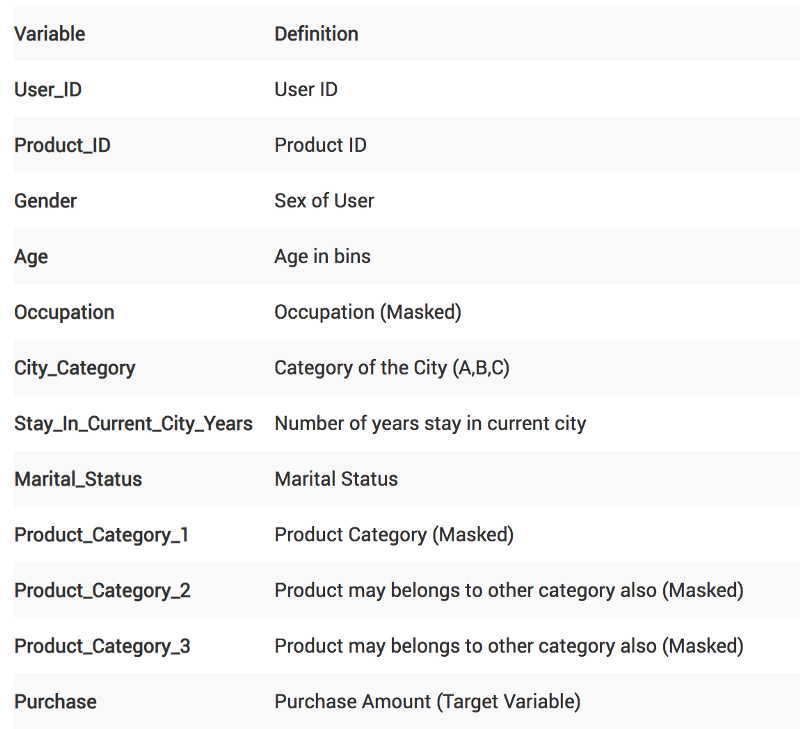

### Problem approach

We will solve the Black-Friday challenge using a basic Neural Network (NN) model using keras.  The idea is to show how we can build an NN model on a structured dataset (it is similar to building a SVM or RF model using scikit-learn). 

We can separate the workflow in 4 main sub-sections:

1. Data Preparation
2. Model Building (Random Forest and Neural Network)
3. Evaluation
4. Prediction

### 1. Data Preparation

First import the necessary libraries to load the dataset, combine train and test to perform preprocessing together, and also create a flag for the same.

In [1]:
#Libraries for data preparation
import pandas as pd
import numpy as np

#Read data files
train = pd.read_csv("data/train_black_friday.csv")
test = pd.read_csv("data/test_black_friday.csv")

#Combined both Train and Test Data set to do preprocessing together # and set flag for both as well
train['Type'] = 'Train' 
test['Type'] = 'Test'
fullData = pd.concat([train,test],axis=0)

/home/onofre/anaconda3/envs/UABC_ML_Workshop_py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


In [2]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Type
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,Train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,Train
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,Train
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,Train
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,Train


In [3]:
fullData.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,Type,User_ID
0,0-17,A,F,0,10,3,NaN,NaN,P00069042,8370.0,2,Train,1000001
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,15200.0,2,Train,1000001
2,0-17,A,F,0,10,12,NaN,NaN,P00087842,1422.0,2,Train,1000001
3,0-17,A,F,0,10,12,14.0,NaN,P00085442,1057.0,2,Train,1000001
4,55+,C,M,0,16,8,NaN,NaN,P00285442,7969.0,4+,Train,1000002


#### Impute missing values

**Impute Missing Values:** Methods to treat missing values for categorical and continuous variables can be different.

Our first step is to identify the ID column, target variable, categorical and continuous independent variables. 

Afterwards, we will create dummy flags for missing values. Why do this? **Because sometimes missing values themselves can carry a good amount of information**. 

Finally, we will impute the missing values of continuous variables with the **mean** of each column, and for the categorical variable, we will create a **new level**.

*Categorical vs Continous data:* http://www.statsoft.com/Textbook/Statistical-Advisor/Continuous-vs-Categorical-Data

In [4]:
#Identifying ID, Categorical
ID_col = ['User_ID','Product_ID'] # relate User and Product
flag_col= ['Type']
target_col = ["Purchase"] # target variable
cat_cols= ['Gender','Age','City_Category','Stay_In_Current_City_Years'] # categorical columns
num_cols= list(set(list(fullData.columns))-set(cat_cols)-set(ID_col)-set(target_col)-set(flag_col)) # numerical columns

In [5]:
cat_cols

['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [6]:
num_cols

['Marital_Status',
 'Product_Category_3',
 'Product_Category_2',
 'Product_Category_1',
 'Occupation']

In [7]:
# Combined numerical and Categorical variables
num_cat_cols = num_cols+cat_cols

#Create a new variable for each variable having MISSING VALUE (NaN) with VariableName_NA 
# and flag missing value with 1 and other with 0

for var in num_cat_cols:
    if fullData[var].isnull().any()==True: # find NaN values for every column in fullData
        fullData[var+'_NA']=fullData[var].isnull()*1 # create new column

#Impute numerical missing values with MEAN
fullData[num_cols] = fullData[num_cols].fillna(fullData[num_cols].mean())

#Impute categorical missing values with -9999
fullData[cat_cols] = fullData[cat_cols].fillna(value = -9999)

In [8]:
fullData.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,Type,User_ID,Product_Category_3_NA,Product_Category_2_NA
0,0-17,A,F,0,10,3,9.844506,12.668605,P00069042,8370.0,2,Train,1000001,1,1
1,0-17,A,F,0,10,1,6.000000,14.000000,P00248942,15200.0,2,Train,1000001,0,0
2,0-17,A,F,0,10,12,9.844506,12.668605,P00087842,1422.0,2,Train,1000001,1,1
3,0-17,A,F,0,10,12,14.000000,12.668605,P00085442,1057.0,2,Train,1000001,1,0
4,55+,C,M,0,16,8,9.844506,12.668605,P00285442,7969.0,4+,Train,1000002,1,1


#### Treating Categorical Values: We will create a label encoder for these variables.

In [9]:
cat_cols

['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [10]:
#create label encoders for categorical features
from sklearn.preprocessing import LabelEncoder

for var in cat_cols:
    number = LabelEncoder()
    #print(number.fi
    fullData[var] = number.fit_transform(fullData[var].astype('str'))

In [11]:
# cat_cols affected: ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
fullData.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,Type,User_ID,Product_Category_3_NA,Product_Category_2_NA
0,0,0,0,0,10,3,9.844506,12.668605,P00069042,8370.0,2,Train,1000001,1,1
1,0,0,0,0,10,1,6.000000,14.000000,P00248942,15200.0,2,Train,1000001,0,0
2,0,0,0,0,10,12,9.844506,12.668605,P00087842,1422.0,2,Train,1000001,1,1
3,0,0,0,0,10,12,14.000000,12.668605,P00085442,1057.0,2,Train,1000001,1,0
4,6,2,1,0,16,8,9.844506,12.668605,P00285442,7969.0,4,Train,1000002,1,1


In [12]:
# Label encoders for flag variables (Type coliumn,Train -> 1, Test -> 0)
#create label encoders for categorical features
from sklearn.preprocessing import LabelEncoder

for var in flag_col:
    number = LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))

In [13]:
fullData.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,Type,User_ID,Product_Category_3_NA,Product_Category_2_NA
0,0,0,0,0,10,3,9.844506,12.668605,P00069042,8370.0,2,1,1000001,1,1
1,0,0,0,0,10,1,6.000000,14.000000,P00248942,15200.0,2,1,1000001,0,0
2,0,0,0,0,10,12,9.844506,12.668605,P00087842,1422.0,2,1,1000001,1,1
3,0,0,0,0,10,12,14.000000,12.668605,P00085442,1057.0,2,1,1000001,1,0
4,6,2,1,0,16,8,9.844506,12.668605,P00285442,7969.0,4,1,1000002,1,1


In [14]:
# To know the type of variables in pandas dataframe
fullData.dtypes

Age                             int64
City_Category                   int64
Gender                          int64
Marital_Status                  int64
Occupation                      int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Product_ID                     object
Purchase                      float64
Stay_In_Current_City_Years      int64
Type                            int64
User_ID                         int64
Product_Category_3_NA           int64
Product_Category_2_NA           int64
dtype: object

In [15]:
#################################################

In [16]:
## FIRST CREATE VALIDATION SET THEN NORMALIZE (BECAUSE TYPE COLUMN IS A STRING!!)

#### Normalize Data: Scale (normalize) the independent variables between 0 and 1. It will helps to converge comparatively faster.

Why do we need to normalize our data? https://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work

In [17]:
print(set(ID_col))
print(set(target_col))
print(set(flag_col))

set(['User_ID', 'Product_ID'])
set(['Purchase'])
set(['Type'])


In [18]:
# feature variables to train model (omit product_id, user_id, purchase)
#features = list(set(list(fullData.columns))-set(ID_col)-set(target_col)-set(flag_col))
features = list(set(list(fullData.columns))-set(ID_col)-set(target_col))
print(features)

['Product_Category_3', 'Product_Category_2', 'Product_Category_1', 'Stay_In_Current_City_Years', 'Gender', 'Age', 'Marital_Status', 'Product_Category_2_NA', 'City_Category', 'Product_Category_3_NA', 'Type', 'Occupation']


In [19]:
fullData[features] = fullData[features]/(fullData[features].max())

# Other built-in method to normalize:

#from sklearn import preprocessing
#x = fullData[features].values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#fullData[features] = pandas.DataFrame(x_scaled)

In [20]:
fullData[features].head() # Now data ranges from 0 to 1 values

,Product_Category_3,Product_Category_2,Product_Category_1,Stay_In_Current_City_Years,Gender,Age,Marital_Status,Product_Category_2_NA,City_Category,Product_Category_3_NA,Type,Occupation
0,0.703811,0.546917,0.15,0.5,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.5
1,0.777778,0.333333,0.05,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5
2,0.703811,0.546917,0.60,0.5,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.5
3,0.703811,0.777778,0.60,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5
4,0.703811,0.546917,0.40,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.8


In [21]:
###################################################

#### Create a validation Set

Here, we will segregate the **train-test** from the full dataset and remove the train-test flag from features list. 

**While building our model, we have target values for the train dataset only, so we will create a validation set out of this train dataset for evaluating the model’s performance**. 

Here, we'll use the method *train_test_split* to divide the train dataset in training and validation in a 70:30 ratio.

In [22]:
# Create a validation set
from sklearn.model_selection import train_test_split

train = fullData[fullData['Type']==1] # type 1 encoding for train data
test = fullData[fullData['Type']==0] # type 0 encoding for test data
features = list(set(list(fullData.columns))-set(ID_col)-set(target_col)-set(flag_col)) #removing target and flag variables

# Note: Both X and y come from the TRAIN set (not touching the TEST set)
X = train[features].values # numpy arrays
y = train[target_col].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42) # 30% for validation

In [23]:
print(len(X_train)) # 70% data
print(len(X_valid)) # 30% data

385047
165021


In [24]:
print(X_train.shape) # We'll be working with 11 features

(385047, 11)


#### This is where the data processing step ends. Next is to construct the (regression) model

### 2. Model building using a Multilayer Perceptron (with Keras)

We'll focus on the steps to build a **basic** deep learning model. This serves as a bottomline design for creating variations in the future. The steps to do this are:
1. Define 
2. Compile
3. Fit

**1. Define Neural Network Model:**

For building a deep learning model, we need to define the layers *(Input, Hidden, and Output)*. Here, we will go ahead with a *sequential* model, which means that we will define layers sequentially. Also, we will be going ahead with a fully connected network (MLP).
1. **Input Layer:** This can be specified while creating the first (hidden) layer with the input dim argument and setting it to 11 for the 11 independent variables. 
2. **Define the number of hidden layer(s)** along with the **number of neurons** and **activation functions**. The right number can be achieved by going through multiple iterations. Higher the number, more complex is your model. To start with, we'll simply use *two* hidden layers. One has 100 neurons and the other has 50 with the same activation function - “relu”.
3. **Finally, we define the output layer with 1 neuron to predict the purchase amount**. The problem in hand is a *regression challenge* so we can go ahead with a *linear transformation* at the output layer. Therefore, there is no need to mention any activation function (it is linear by default).

#### Must have Tensorflow and Keras installed!!

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2017/12/not_santa_detector_dl_logos.jpg")

**TensorFlow**

"TensorFlow is a tool for machine learning. While it contains a wide range of functionality, TensorFlow is mainly designed for deep neural network models".

In [26]:
import platform
print(platform.python_version())

2.7.15


In [27]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

Hello, TensorFlow!


**Keras** is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.

In [32]:
from keras.models import Sequential
from keras.layers import Activation, Dense

In [33]:
# Define model
model = Sequential() # Keras 
model.add(Dense(100, input_dim=11, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))
model.summary() #Print model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,301
Trainable params: 6,301
Non-trainable params: 0
_________________________________________________________________


![title](images/MLP Architecture.png)

**2. Compile Model**

We now configure the model for **training**. We will set the optimizer to change the *weights* and *biases*, and the *loss function* and *metric* to evaluate the model’s performance. 

Here, we will use “adam” as the optimizer, “mean squared error” as the loss metric. Depending on the type of problem we are solving, we can change our loss and metrics. For binary classification, we use “binary-crossentropy” as a loss function.

- A note on optimization algorithms in Neural Networks: https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- A note on ADAM optimizer: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

- A note on RMSE metric to evaluate performance: http://statweb.stanford.edu/~susan/courses/s60/split/node60.html
![title](images/RMSE.png)


In [35]:
# Compile model
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

**3. Fit Model** 

The final step of model building is fitting the model on the training dataset (which is actually 70% of the full dataset). We need to provide both independent and dependent variables along with the number of training iterations, i.e. epochs. Here, we have taken 10 epochs.

In [36]:
# Fit Model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
385047/385047 [==============================] - 8s 20us/step - loss: 25338582.6772 - mean_squared_error: 25338582.6772
Epoch 2/10
385047/385047 [==============================] - 7s 19us/step - loss: 20056371.5715 - mean_squared_error: 20056371.5715
Epoch 3/10
385047/385047 [==============================] - 8s 20us/step - loss: 18193476.7034 - mean_squared_error: 18193476.7034
Epoch 4/10
385047/385047 [==============================] - 7s 19us/step - loss: 17741891.4968 - mean_squared_error: 17741891.4968
Epoch 5/10
385047/385047 [==============================] - 8s 19us/step - loss: 17698009.0084 - mean_squared_error: 17698009.0084
Epoch 6/10
385047/385047 [==============================] - 8s 21us/step - loss: 17693232.3034 - mean_squared_error: 17693232.3034
Epoch 7/10
385047/385047 [==============================] - 8s 22us/step - loss: 17688258.3076 - mean_squared_error: 17688258.3076
Epoch 8/10
385047/385047 [==============================] - 8s 21us/step - loss: 17

### 3. Evaluation

Now that we have built the model using Neural Network techniques, the next step is to evaluate the performance on the validation dataset for both the models.


Evaluation for Neural Network Model: We will get the predictions on the validation dataset using the neural network model and calculate the root mean squared error. RMSE with a basic NN model comes out to be **~4208**. 

This is a fairly basic model, we can go ahead and tune the hyper-parameters to build a more complex network. 

You can pass validation data as an argument while fitting the NN model as well to look at the validation score after each epoch.

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
pred= model.predict(X_valid)
score = np.sqrt(mean_squared_error(y_valid,pred)) # we implement the formula above
print (score)
#4213.954523194906

4208.533171754375


### 4. Predictions

After evaluating the model and finalizing the model parameters, we can go ahead with the prediction on the **test data**. 

In [40]:
#Select the independent variables for test dataset
X_test = test[features].values

#Prediction using Neural Network
y_test_nn = model.predict(X_test)

In [41]:
print(y_test_nn)

[[13324.077 ]
 [ 9195.906 ]
 [ 6938.99  ]
 ...
 [13565.367 ]
 [ 7931.7007]
 [ 6922.3345]]


In [43]:
type(y_test_nn) ##plot, interpret predictions

numpy.ndarray

### What’s Next

The initial idea was to show how we can build an NN model on a structured dataset, therefore, we have not focused on other aspects of improving the model’s predictions. Below is a list of ideas which you can apply to build on the neural network:

    Feature Engineering (Product Ids may have some information about the purchase amount)
    Select right hyper-parameters
    Build a more complex network by adding more hidden layers
    Use regularization
    Train for more number of epochs
    Take Ensemble of both RF with NN model